# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [23]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [24]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/0.4.0/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [25]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [26]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    trans = transforms.Compose([transforms.Resize((image_size, image_size)),
                                transforms.ToTensor()])
    data = datasets.ImageFolder(data_dir, transform=trans)
    dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [27]:
# Define function hyperparameters
batch_size = 128
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should see square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

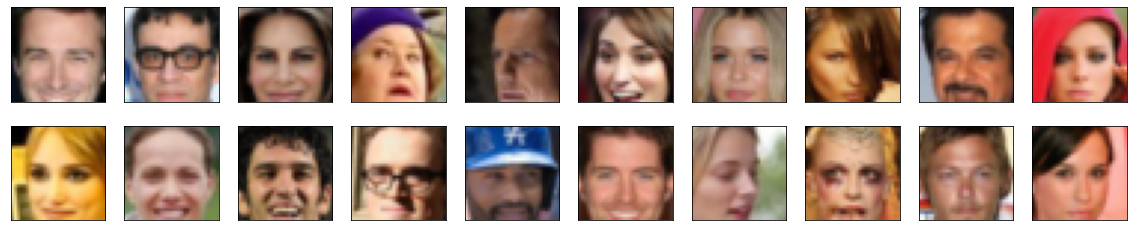

In [28]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [29]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(0.8980)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [31]:
import torch.nn as nn
import torch.nn.functional as F

In [32]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    layers.append(conv_layer)
    
    if batch_norm is True:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [35]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # 32x32
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        # 16x16
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        # 8x8
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        # 4x4
        self.conv4 = conv(conv_dim*4, conv_dim*8, 4)
        # 2x2
        self.fc = nn.Linear(2*2*conv_dim*8, 1)
        # 1x1x1
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        # convolutional layers
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = F.leaky_relu(self.conv4(x), 0.2)
        
        # flatten input to fully connected layer
        x = x.view(-1, 2*2*self.conv_dim*8)
        
        # fully connected layer
        x = self.fc(x)

        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [13]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
    layers.append(deconv_layer)
    
    if batch_norm is True:
        layers.append(nn.BatchNorm2d(out_channels))
    
    return nn.Sequential(*layers)

In [37]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # linear layer
        self.fc = nn.Linear(z_size, 2 * 2 * conv_dim*8)
        
        # transpose convolutional layers
        # 2x2
        self.deconv1 = deconv(conv_dim*8, conv_dim*4, 4)
        # 4x4
        self.deconv2 = deconv(conv_dim*4, conv_dim*2, 4)
        # 8x8
        self.deconv3 = deconv(conv_dim*2, conv_dim, 4)
        # 16x16
        self.deconv4 = deconv(conv_dim, 3, 4, batch_norm=False)
        # 32x32

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        
        x = x.view(-1, self.conv_dim*8, 2, 2)
        
        x = F.relu(self.deconv1(x))        
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        x = F.tanh(self.deconv4(x))
        
        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [42]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0, 0.02)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [43]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [44]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 128

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=4096, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=128, out_features=4096, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, 

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [45]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [51]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    loss = torch.mean((D_out - 1)**2)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    loss = torch.mean(D_out**2)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [48]:
import torch.optim as optim

# parameters
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [54]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # train with real images
            D_out_real = D(real_images)
            d_real_loss = real_loss(D_out_real)
            
            # generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # train with fake images
            D_out_fake = D(fake_images)
            d_fake_loss = fake_loss(D_out_fake)
            
            d_loss = d_real_loss + d_fake_loss
            
            d_loss.backward()
            d_optimizer.step()
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # generate fake_images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            # train on fake images using flipped labels
            D_out_fake = D(fake_images)
            g_loss = real_loss(D_out_fake)
            
            g_loss.backward()
            g_optimizer.step()
                        
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        with torch.no_grad():
            samples_z = G(fixed_z)
            samples_z = samples_z.detach().cpu()
            samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [55]:
# set number of epochs 
n_epochs = 200


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  200] | d_loss: 2.0930 | g_loss: 4.2350
Epoch [    1/  200] | d_loss: 0.1840 | g_loss: 1.3949
Epoch [    1/  200] | d_loss: 0.0879 | g_loss: 0.9049
Epoch [    1/  200] | d_loss: 0.0477 | g_loss: 1.1721
Epoch [    1/  200] | d_loss: 0.0314 | g_loss: 1.3516
Epoch [    1/  200] | d_loss: 0.0430 | g_loss: 1.8064
Epoch [    1/  200] | d_loss: 0.0163 | g_loss: 1.2436
Epoch [    1/  200] | d_loss: 0.0697 | g_loss: 1.5961
Epoch [    1/  200] | d_loss: 0.0109 | g_loss: 1.1417
Epoch [    1/  200] | d_loss: 0.1361 | g_loss: 2.1645
Epoch [    1/  200] | d_loss: 0.0077 | g_loss: 1.1027
Epoch [    1/  200] | d_loss: 0.1362 | g_loss: 0.4511
Epoch [    1/  200] | d_loss: 0.0090 | g_loss: 1.1627
Epoch [    1/  200] | d_loss: 0.0094 | g_loss: 1.0380
Epoch [    1/  200] | d_loss: 0.0069 | g_loss: 1.3088
Epoch [    2/  200] | d_loss: 0.0125 | g_loss: 1.2737
Epoch [    2/  200] | d_loss: 0.0088 | g_loss: 1.1067
Epoch [    2/  200] | d_loss: 0.0093 | g_loss: 1.2421
Epoch [    2/  200] | d_loss

Epoch [   11/  200] | d_loss: 0.1729 | g_loss: 0.5926
Epoch [   11/  200] | d_loss: 0.1748 | g_loss: 1.0252
Epoch [   11/  200] | d_loss: 0.1366 | g_loss: 0.5563
Epoch [   11/  200] | d_loss: 0.1543 | g_loss: 0.8343
Epoch [   11/  200] | d_loss: 0.1789 | g_loss: 0.9231
Epoch [   11/  200] | d_loss: 0.3464 | g_loss: 0.4119
Epoch [   11/  200] | d_loss: 0.5895 | g_loss: 0.4279
Epoch [   11/  200] | d_loss: 0.1797 | g_loss: 0.6462
Epoch [   11/  200] | d_loss: 0.2042 | g_loss: 0.6145
Epoch [   11/  200] | d_loss: 0.1518 | g_loss: 0.8759
Epoch [   11/  200] | d_loss: 0.1983 | g_loss: 1.2362
Epoch [   11/  200] | d_loss: 0.2132 | g_loss: 0.8101
Epoch [   11/  200] | d_loss: 0.1849 | g_loss: 0.6439
Epoch [   12/  200] | d_loss: 0.0907 | g_loss: 1.0119
Epoch [   12/  200] | d_loss: 0.1313 | g_loss: 0.8041
Epoch [   12/  200] | d_loss: 0.1711 | g_loss: 1.0879
Epoch [   12/  200] | d_loss: 0.3310 | g_loss: 0.5262
Epoch [   12/  200] | d_loss: 0.1114 | g_loss: 0.7207
Epoch [   12/  200] | d_loss

Epoch [   21/  200] | d_loss: 0.0760 | g_loss: 1.0262
Epoch [   21/  200] | d_loss: 0.0807 | g_loss: 0.9820
Epoch [   21/  200] | d_loss: 0.1546 | g_loss: 0.5588
Epoch [   21/  200] | d_loss: 0.1464 | g_loss: 1.7442
Epoch [   21/  200] | d_loss: 0.0744 | g_loss: 0.9128
Epoch [   21/  200] | d_loss: 0.0565 | g_loss: 0.9502
Epoch [   21/  200] | d_loss: 0.1358 | g_loss: 0.7797
Epoch [   21/  200] | d_loss: 0.0711 | g_loss: 1.4207
Epoch [   21/  200] | d_loss: 0.0987 | g_loss: 0.7284
Epoch [   21/  200] | d_loss: 0.2769 | g_loss: 0.6715
Epoch [   21/  200] | d_loss: 0.0408 | g_loss: 1.1375
Epoch [   22/  200] | d_loss: 0.1006 | g_loss: 1.0103
Epoch [   22/  200] | d_loss: 0.2007 | g_loss: 0.7802
Epoch [   22/  200] | d_loss: 0.0636 | g_loss: 0.9476
Epoch [   22/  200] | d_loss: 0.3005 | g_loss: 1.5625
Epoch [   22/  200] | d_loss: 0.0758 | g_loss: 1.2710
Epoch [   22/  200] | d_loss: 0.0954 | g_loss: 1.0006
Epoch [   22/  200] | d_loss: 0.0337 | g_loss: 0.7889
Epoch [   22/  200] | d_loss

Epoch [   31/  200] | d_loss: 0.0979 | g_loss: 0.6047
Epoch [   31/  200] | d_loss: 0.1010 | g_loss: 0.7771
Epoch [   31/  200] | d_loss: 0.0344 | g_loss: 0.9763
Epoch [   31/  200] | d_loss: 0.1602 | g_loss: 1.5827
Epoch [   31/  200] | d_loss: 0.0927 | g_loss: 1.0738
Epoch [   31/  200] | d_loss: 0.0361 | g_loss: 1.0030
Epoch [   31/  200] | d_loss: 0.1362 | g_loss: 1.1369
Epoch [   31/  200] | d_loss: 0.1723 | g_loss: 0.5901
Epoch [   31/  200] | d_loss: 0.0394 | g_loss: 0.9832
Epoch [   32/  200] | d_loss: 0.1278 | g_loss: 0.6376
Epoch [   32/  200] | d_loss: 0.3168 | g_loss: 1.8676
Epoch [   32/  200] | d_loss: 0.0974 | g_loss: 1.4588
Epoch [   32/  200] | d_loss: 0.0655 | g_loss: 0.6956
Epoch [   32/  200] | d_loss: 0.0665 | g_loss: 0.8826
Epoch [   32/  200] | d_loss: 0.0834 | g_loss: 1.3389
Epoch [   32/  200] | d_loss: 0.0754 | g_loss: 0.9146
Epoch [   32/  200] | d_loss: 0.1734 | g_loss: 0.6454
Epoch [   32/  200] | d_loss: 0.0973 | g_loss: 0.7485
Epoch [   32/  200] | d_loss

Epoch [   41/  200] | d_loss: 0.0441 | g_loss: 1.0255
Epoch [   41/  200] | d_loss: 0.1256 | g_loss: 1.3274
Epoch [   41/  200] | d_loss: 0.0213 | g_loss: 1.1321
Epoch [   41/  200] | d_loss: 0.0394 | g_loss: 1.1392
Epoch [   41/  200] | d_loss: 0.0890 | g_loss: 1.1400
Epoch [   41/  200] | d_loss: 0.0710 | g_loss: 1.1458
Epoch [   41/  200] | d_loss: 0.0676 | g_loss: 0.8418
Epoch [   42/  200] | d_loss: 0.0243 | g_loss: 1.1421
Epoch [   42/  200] | d_loss: 0.1966 | g_loss: 1.7501
Epoch [   42/  200] | d_loss: 0.0996 | g_loss: 0.8765
Epoch [   42/  200] | d_loss: 0.0216 | g_loss: 1.2116
Epoch [   42/  200] | d_loss: 0.0630 | g_loss: 1.0648
Epoch [   42/  200] | d_loss: 0.1246 | g_loss: 0.7394
Epoch [   42/  200] | d_loss: 0.0663 | g_loss: 0.6325
Epoch [   42/  200] | d_loss: 0.0736 | g_loss: 0.6290
Epoch [   42/  200] | d_loss: 0.0253 | g_loss: 1.3582
Epoch [   42/  200] | d_loss: 0.0276 | g_loss: 1.4904
Epoch [   42/  200] | d_loss: 0.0350 | g_loss: 1.0149
Epoch [   42/  200] | d_loss

Epoch [   51/  200] | d_loss: 0.0262 | g_loss: 1.0219
Epoch [   51/  200] | d_loss: 0.0187 | g_loss: 1.0100
Epoch [   51/  200] | d_loss: 0.0237 | g_loss: 0.8883
Epoch [   51/  200] | d_loss: 0.1396 | g_loss: 0.5462
Epoch [   51/  200] | d_loss: 0.0801 | g_loss: 0.7269
Epoch [   52/  200] | d_loss: 0.0291 | g_loss: 0.8963
Epoch [   52/  200] | d_loss: 0.0711 | g_loss: 1.0744
Epoch [   52/  200] | d_loss: 0.0754 | g_loss: 0.9200
Epoch [   52/  200] | d_loss: 0.0198 | g_loss: 0.8250
Epoch [   52/  200] | d_loss: 0.0400 | g_loss: 0.7742
Epoch [   52/  200] | d_loss: 0.0341 | g_loss: 0.9168
Epoch [   52/  200] | d_loss: 0.0469 | g_loss: 0.5884
Epoch [   52/  200] | d_loss: 0.0244 | g_loss: 1.2835
Epoch [   52/  200] | d_loss: 0.0950 | g_loss: 0.7772
Epoch [   52/  200] | d_loss: 0.0259 | g_loss: 1.2648
Epoch [   52/  200] | d_loss: 0.0386 | g_loss: 0.6260
Epoch [   52/  200] | d_loss: 0.0662 | g_loss: 1.0732
Epoch [   52/  200] | d_loss: 0.0561 | g_loss: 0.7727
Epoch [   52/  200] | d_loss

Epoch [   61/  200] | d_loss: 0.0207 | g_loss: 0.9626
Epoch [   61/  200] | d_loss: 0.0719 | g_loss: 0.6868
Epoch [   61/  200] | d_loss: 0.0509 | g_loss: 0.8571
Epoch [   62/  200] | d_loss: 0.1079 | g_loss: 0.6616
Epoch [   62/  200] | d_loss: 0.0329 | g_loss: 0.8102
Epoch [   62/  200] | d_loss: 0.0329 | g_loss: 1.3753
Epoch [   62/  200] | d_loss: 0.0701 | g_loss: 0.7048
Epoch [   62/  200] | d_loss: 0.0850 | g_loss: 0.7589
Epoch [   62/  200] | d_loss: 0.0412 | g_loss: 0.9831
Epoch [   62/  200] | d_loss: 0.0194 | g_loss: 1.4312
Epoch [   62/  200] | d_loss: 0.1219 | g_loss: 0.7208
Epoch [   62/  200] | d_loss: 0.0182 | g_loss: 1.3177
Epoch [   62/  200] | d_loss: 0.0431 | g_loss: 0.7104
Epoch [   62/  200] | d_loss: 0.0953 | g_loss: 0.7938
Epoch [   62/  200] | d_loss: 0.0367 | g_loss: 1.0856
Epoch [   62/  200] | d_loss: 0.0421 | g_loss: 1.4135
Epoch [   62/  200] | d_loss: 0.1516 | g_loss: 1.3520
Epoch [   62/  200] | d_loss: 0.0192 | g_loss: 1.0349
Epoch [   63/  200] | d_loss

Epoch [   71/  200] | d_loss: 0.0312 | g_loss: 1.1787
Epoch [   72/  200] | d_loss: 0.0813 | g_loss: 0.8080
Epoch [   72/  200] | d_loss: 0.0228 | g_loss: 1.0682
Epoch [   72/  200] | d_loss: 0.0234 | g_loss: 1.2234
Epoch [   72/  200] | d_loss: 0.0173 | g_loss: 0.7975
Epoch [   72/  200] | d_loss: 0.0163 | g_loss: 1.2303
Epoch [   72/  200] | d_loss: 0.0226 | g_loss: 0.8018
Epoch [   72/  200] | d_loss: 0.0250 | g_loss: 0.9796
Epoch [   72/  200] | d_loss: 0.0281 | g_loss: 1.0590
Epoch [   72/  200] | d_loss: 0.0569 | g_loss: 0.7443
Epoch [   72/  200] | d_loss: 0.0259 | g_loss: 0.8118
Epoch [   72/  200] | d_loss: 0.0563 | g_loss: 1.3513
Epoch [   72/  200] | d_loss: 0.0568 | g_loss: 0.8042
Epoch [   72/  200] | d_loss: 0.0218 | g_loss: 1.1461
Epoch [   72/  200] | d_loss: 0.0669 | g_loss: 1.5077
Epoch [   72/  200] | d_loss: 0.0511 | g_loss: 1.1310
Epoch [   73/  200] | d_loss: 0.0311 | g_loss: 0.9197
Epoch [   73/  200] | d_loss: 0.0317 | g_loss: 0.7499
Epoch [   73/  200] | d_loss

Epoch [   82/  200] | d_loss: 0.0662 | g_loss: 1.0144
Epoch [   82/  200] | d_loss: 0.0319 | g_loss: 0.9977
Epoch [   82/  200] | d_loss: 0.0225 | g_loss: 1.1201
Epoch [   82/  200] | d_loss: 0.0179 | g_loss: 1.1075
Epoch [   82/  200] | d_loss: 0.0216 | g_loss: 1.2088
Epoch [   82/  200] | d_loss: 0.0237 | g_loss: 0.6461
Epoch [   82/  200] | d_loss: 0.0245 | g_loss: 0.8195
Epoch [   82/  200] | d_loss: 0.0216 | g_loss: 0.9394
Epoch [   82/  200] | d_loss: 0.0422 | g_loss: 0.7710
Epoch [   82/  200] | d_loss: 0.0281 | g_loss: 0.9472
Epoch [   82/  200] | d_loss: 0.0229 | g_loss: 0.9153
Epoch [   82/  200] | d_loss: 0.0746 | g_loss: 1.2037
Epoch [   82/  200] | d_loss: 0.0450 | g_loss: 1.1771
Epoch [   82/  200] | d_loss: 0.0592 | g_loss: 0.9899
Epoch [   83/  200] | d_loss: 0.1834 | g_loss: 1.5200
Epoch [   83/  200] | d_loss: 0.0589 | g_loss: 0.8861
Epoch [   83/  200] | d_loss: 0.0179 | g_loss: 0.9588
Epoch [   83/  200] | d_loss: 0.0159 | g_loss: 1.0846
Epoch [   83/  200] | d_loss

Epoch [   92/  200] | d_loss: 0.0166 | g_loss: 1.1104
Epoch [   92/  200] | d_loss: 0.0275 | g_loss: 0.7159
Epoch [   92/  200] | d_loss: 0.1108 | g_loss: 0.9416
Epoch [   92/  200] | d_loss: 0.0318 | g_loss: 1.0467
Epoch [   92/  200] | d_loss: 0.0474 | g_loss: 1.0879
Epoch [   92/  200] | d_loss: 0.0303 | g_loss: 0.8687
Epoch [   92/  200] | d_loss: 0.0207 | g_loss: 1.1288
Epoch [   92/  200] | d_loss: 0.0572 | g_loss: 1.0748
Epoch [   92/  200] | d_loss: 0.0206 | g_loss: 1.1049
Epoch [   92/  200] | d_loss: 0.0425 | g_loss: 1.0322
Epoch [   92/  200] | d_loss: 0.0298 | g_loss: 0.9002
Epoch [   92/  200] | d_loss: 0.0370 | g_loss: 1.2658
Epoch [   93/  200] | d_loss: 0.0243 | g_loss: 1.0267
Epoch [   93/  200] | d_loss: 0.0863 | g_loss: 1.1444
Epoch [   93/  200] | d_loss: 0.1249 | g_loss: 1.4796
Epoch [   93/  200] | d_loss: 0.0342 | g_loss: 0.9310
Epoch [   93/  200] | d_loss: 0.0768 | g_loss: 1.2417
Epoch [   93/  200] | d_loss: 0.0210 | g_loss: 0.8527
Epoch [   93/  200] | d_loss

Epoch [  102/  200] | d_loss: 0.0219 | g_loss: 0.9822
Epoch [  102/  200] | d_loss: 0.0118 | g_loss: 1.2205
Epoch [  102/  200] | d_loss: 0.0155 | g_loss: 0.8177
Epoch [  102/  200] | d_loss: 0.0413 | g_loss: 1.3517
Epoch [  102/  200] | d_loss: 0.0242 | g_loss: 0.7454
Epoch [  102/  200] | d_loss: 0.0248 | g_loss: 1.1903
Epoch [  102/  200] | d_loss: 0.0268 | g_loss: 1.1696
Epoch [  102/  200] | d_loss: 0.0144 | g_loss: 1.0397
Epoch [  102/  200] | d_loss: 0.0281 | g_loss: 0.7131
Epoch [  102/  200] | d_loss: 0.0298 | g_loss: 1.0176
Epoch [  103/  200] | d_loss: 0.0125 | g_loss: 1.1623
Epoch [  103/  200] | d_loss: 0.0126 | g_loss: 1.1276
Epoch [  103/  200] | d_loss: 0.0740 | g_loss: 0.8412
Epoch [  103/  200] | d_loss: 0.0532 | g_loss: 0.7110
Epoch [  103/  200] | d_loss: 0.0203 | g_loss: 1.0072
Epoch [  103/  200] | d_loss: 0.0200 | g_loss: 1.2568
Epoch [  103/  200] | d_loss: 0.0262 | g_loss: 0.9863
Epoch [  103/  200] | d_loss: 0.0322 | g_loss: 1.3681
Epoch [  103/  200] | d_loss

Epoch [  112/  200] | d_loss: 0.0201 | g_loss: 0.9980
Epoch [  112/  200] | d_loss: 0.0382 | g_loss: 1.0498
Epoch [  112/  200] | d_loss: 0.0297 | g_loss: 0.9165
Epoch [  112/  200] | d_loss: 0.0149 | g_loss: 0.9273
Epoch [  112/  200] | d_loss: 0.0094 | g_loss: 0.8438
Epoch [  112/  200] | d_loss: 0.0198 | g_loss: 1.0247
Epoch [  112/  200] | d_loss: 0.0151 | g_loss: 1.0177
Epoch [  112/  200] | d_loss: 0.0686 | g_loss: 0.8612
Epoch [  113/  200] | d_loss: 0.0094 | g_loss: 0.9893
Epoch [  113/  200] | d_loss: 0.0177 | g_loss: 0.8209
Epoch [  113/  200] | d_loss: 0.0336 | g_loss: 0.9741
Epoch [  113/  200] | d_loss: 0.0431 | g_loss: 0.8144
Epoch [  113/  200] | d_loss: 0.0666 | g_loss: 1.5497
Epoch [  113/  200] | d_loss: 0.0083 | g_loss: 0.8358
Epoch [  113/  200] | d_loss: 0.0543 | g_loss: 0.7151
Epoch [  113/  200] | d_loss: 0.0283 | g_loss: 0.9557
Epoch [  113/  200] | d_loss: 0.0086 | g_loss: 1.0552
Epoch [  113/  200] | d_loss: 0.0084 | g_loss: 1.0099
Epoch [  113/  200] | d_loss

Epoch [  122/  200] | d_loss: 0.0542 | g_loss: 0.8137
Epoch [  122/  200] | d_loss: 0.0430 | g_loss: 0.9256
Epoch [  122/  200] | d_loss: 0.0424 | g_loss: 1.3190
Epoch [  122/  200] | d_loss: 0.0370 | g_loss: 1.0593
Epoch [  122/  200] | d_loss: 0.0263 | g_loss: 1.4758
Epoch [  122/  200] | d_loss: 0.0230 | g_loss: 1.3936
Epoch [  123/  200] | d_loss: 0.0301 | g_loss: 1.3184
Epoch [  123/  200] | d_loss: 0.0373 | g_loss: 0.4688
Epoch [  123/  200] | d_loss: 0.0261 | g_loss: 1.0530
Epoch [  123/  200] | d_loss: 0.0289 | g_loss: 0.7934
Epoch [  123/  200] | d_loss: 0.0230 | g_loss: 1.2476
Epoch [  123/  200] | d_loss: 0.0174 | g_loss: 1.0960
Epoch [  123/  200] | d_loss: 0.0087 | g_loss: 1.0683
Epoch [  123/  200] | d_loss: 0.0251 | g_loss: 1.0951
Epoch [  123/  200] | d_loss: 0.0208 | g_loss: 1.3474
Epoch [  123/  200] | d_loss: 0.0104 | g_loss: 1.4557
Epoch [  123/  200] | d_loss: 0.0167 | g_loss: 1.0151
Epoch [  123/  200] | d_loss: 0.0126 | g_loss: 1.1888
Epoch [  123/  200] | d_loss

Epoch [  132/  200] | d_loss: 0.0106 | g_loss: 0.9122
Epoch [  132/  200] | d_loss: 0.0315 | g_loss: 0.9727
Epoch [  132/  200] | d_loss: 0.0158 | g_loss: 0.9740
Epoch [  132/  200] | d_loss: 0.0411 | g_loss: 1.4956
Epoch [  133/  200] | d_loss: 0.0135 | g_loss: 1.2879
Epoch [  133/  200] | d_loss: 0.0438 | g_loss: 0.7861
Epoch [  133/  200] | d_loss: 0.0103 | g_loss: 1.1879
Epoch [  133/  200] | d_loss: 0.0475 | g_loss: 0.8282
Epoch [  133/  200] | d_loss: 0.0871 | g_loss: 0.8062
Epoch [  133/  200] | d_loss: 0.0146 | g_loss: 1.0979
Epoch [  133/  200] | d_loss: 0.0390 | g_loss: 0.6567
Epoch [  133/  200] | d_loss: 0.1678 | g_loss: 1.4617
Epoch [  133/  200] | d_loss: 0.0279 | g_loss: 1.0179
Epoch [  133/  200] | d_loss: 0.0081 | g_loss: 0.9369
Epoch [  133/  200] | d_loss: 0.0167 | g_loss: 0.9400
Epoch [  133/  200] | d_loss: 0.0291 | g_loss: 0.9590
Epoch [  133/  200] | d_loss: 0.0360 | g_loss: 0.7889
Epoch [  133/  200] | d_loss: 0.0125 | g_loss: 1.2131
Epoch [  133/  200] | d_loss

Epoch [  142/  200] | d_loss: 0.0600 | g_loss: 0.7726
Epoch [  142/  200] | d_loss: 0.0181 | g_loss: 0.9132
Epoch [  143/  200] | d_loss: 0.0389 | g_loss: 1.4341
Epoch [  143/  200] | d_loss: 0.0218 | g_loss: 1.2491
Epoch [  143/  200] | d_loss: 0.0225 | g_loss: 0.8060
Epoch [  143/  200] | d_loss: 0.0109 | g_loss: 0.8111
Epoch [  143/  200] | d_loss: 0.0121 | g_loss: 1.0992
Epoch [  143/  200] | d_loss: 0.0223 | g_loss: 1.2234
Epoch [  143/  200] | d_loss: 0.0471 | g_loss: 1.2389
Epoch [  143/  200] | d_loss: 0.0127 | g_loss: 0.9329
Epoch [  143/  200] | d_loss: 0.0244 | g_loss: 0.8459
Epoch [  143/  200] | d_loss: 0.0226 | g_loss: 1.0571
Epoch [  143/  200] | d_loss: 0.0107 | g_loss: 1.0272
Epoch [  143/  200] | d_loss: 0.0091 | g_loss: 1.0300
Epoch [  143/  200] | d_loss: 0.0680 | g_loss: 0.9003
Epoch [  143/  200] | d_loss: 0.0079 | g_loss: 1.1886
Epoch [  143/  200] | d_loss: 0.0141 | g_loss: 0.8725
Epoch [  144/  200] | d_loss: 0.0111 | g_loss: 0.7466
Epoch [  144/  200] | d_loss

Epoch [  153/  200] | d_loss: 0.1126 | g_loss: 1.4383
Epoch [  153/  200] | d_loss: 0.0072 | g_loss: 1.2574
Epoch [  153/  200] | d_loss: 0.0554 | g_loss: 1.3134
Epoch [  153/  200] | d_loss: 0.0291 | g_loss: 1.1348
Epoch [  153/  200] | d_loss: 0.0304 | g_loss: 0.9787
Epoch [  153/  200] | d_loss: 0.0204 | g_loss: 0.8111
Epoch [  153/  200] | d_loss: 0.0091 | g_loss: 0.9859
Epoch [  153/  200] | d_loss: 0.0333 | g_loss: 0.7392
Epoch [  153/  200] | d_loss: 0.0227 | g_loss: 0.9783
Epoch [  153/  200] | d_loss: 0.0146 | g_loss: 0.9299
Epoch [  153/  200] | d_loss: 0.0344 | g_loss: 1.4001
Epoch [  153/  200] | d_loss: 0.0673 | g_loss: 0.6926
Epoch [  153/  200] | d_loss: 0.0071 | g_loss: 1.1458
Epoch [  153/  200] | d_loss: 0.0476 | g_loss: 1.5728
Epoch [  153/  200] | d_loss: 0.0067 | g_loss: 0.9472
Epoch [  154/  200] | d_loss: 0.0248 | g_loss: 0.8567
Epoch [  154/  200] | d_loss: 0.0124 | g_loss: 1.0629
Epoch [  154/  200] | d_loss: 0.0074 | g_loss: 1.1587
Epoch [  154/  200] | d_loss

Epoch [  163/  200] | d_loss: 0.0147 | g_loss: 0.7995
Epoch [  163/  200] | d_loss: 0.0091 | g_loss: 0.9363
Epoch [  163/  200] | d_loss: 0.0086 | g_loss: 1.3977
Epoch [  163/  200] | d_loss: 0.0256 | g_loss: 0.9571
Epoch [  163/  200] | d_loss: 0.0090 | g_loss: 0.9897
Epoch [  163/  200] | d_loss: 0.0090 | g_loss: 1.0391
Epoch [  163/  200] | d_loss: 0.0214 | g_loss: 0.7482
Epoch [  163/  200] | d_loss: 0.1313 | g_loss: 0.8228
Epoch [  163/  200] | d_loss: 0.0106 | g_loss: 1.0627
Epoch [  163/  200] | d_loss: 0.0177 | g_loss: 0.6964
Epoch [  163/  200] | d_loss: 0.0125 | g_loss: 1.1084
Epoch [  163/  200] | d_loss: 0.0657 | g_loss: 0.9195
Epoch [  163/  200] | d_loss: 0.0428 | g_loss: 0.8982
Epoch [  164/  200] | d_loss: 0.0488 | g_loss: 1.3482
Epoch [  164/  200] | d_loss: 0.0203 | g_loss: 1.1121
Epoch [  164/  200] | d_loss: 0.0322 | g_loss: 0.9964
Epoch [  164/  200] | d_loss: 0.0426 | g_loss: 1.0657
Epoch [  164/  200] | d_loss: 0.0363 | g_loss: 1.1822
Epoch [  164/  200] | d_loss

Epoch [  173/  200] | d_loss: 0.0123 | g_loss: 1.1653
Epoch [  173/  200] | d_loss: 0.0128 | g_loss: 0.9031
Epoch [  173/  200] | d_loss: 0.0209 | g_loss: 1.0225
Epoch [  173/  200] | d_loss: 0.0069 | g_loss: 0.9542
Epoch [  173/  200] | d_loss: 0.0106 | g_loss: 0.9135
Epoch [  173/  200] | d_loss: 0.0303 | g_loss: 0.8529
Epoch [  173/  200] | d_loss: 0.0051 | g_loss: 1.1517
Epoch [  173/  200] | d_loss: 0.0143 | g_loss: 0.7350
Epoch [  173/  200] | d_loss: 0.0081 | g_loss: 1.2451
Epoch [  173/  200] | d_loss: 0.0065 | g_loss: 1.3013
Epoch [  173/  200] | d_loss: 0.0188 | g_loss: 1.3356
Epoch [  174/  200] | d_loss: 0.0230 | g_loss: 1.2309
Epoch [  174/  200] | d_loss: 0.0180 | g_loss: 1.1366
Epoch [  174/  200] | d_loss: 0.0378 | g_loss: 1.2351
Epoch [  174/  200] | d_loss: 0.0206 | g_loss: 0.8510
Epoch [  174/  200] | d_loss: 0.0078 | g_loss: 1.0331
Epoch [  174/  200] | d_loss: 0.0499 | g_loss: 0.9038
Epoch [  174/  200] | d_loss: 0.0113 | g_loss: 0.9904
Epoch [  174/  200] | d_loss

Epoch [  183/  200] | d_loss: 0.0067 | g_loss: 1.0133
Epoch [  183/  200] | d_loss: 0.0070 | g_loss: 1.1587
Epoch [  183/  200] | d_loss: 0.0188 | g_loss: 1.0189
Epoch [  183/  200] | d_loss: 0.0324 | g_loss: 0.8643
Epoch [  183/  200] | d_loss: 0.0071 | g_loss: 1.1702
Epoch [  183/  200] | d_loss: 0.0224 | g_loss: 1.1882
Epoch [  183/  200] | d_loss: 0.0160 | g_loss: 1.0793
Epoch [  183/  200] | d_loss: 0.0427 | g_loss: 0.9044
Epoch [  183/  200] | d_loss: 0.0311 | g_loss: 1.1369
Epoch [  184/  200] | d_loss: 0.0092 | g_loss: 1.2576
Epoch [  184/  200] | d_loss: 0.0131 | g_loss: 0.9547
Epoch [  184/  200] | d_loss: 0.0103 | g_loss: 0.8073
Epoch [  184/  200] | d_loss: 0.0094 | g_loss: 0.9560
Epoch [  184/  200] | d_loss: 0.0067 | g_loss: 1.3926
Epoch [  184/  200] | d_loss: 0.0347 | g_loss: 1.3532
Epoch [  184/  200] | d_loss: 0.0092 | g_loss: 1.2159
Epoch [  184/  200] | d_loss: 0.0130 | g_loss: 1.1674
Epoch [  184/  200] | d_loss: 0.0386 | g_loss: 0.9624
Epoch [  184/  200] | d_loss

Epoch [  193/  200] | d_loss: 0.0214 | g_loss: 1.2031
Epoch [  193/  200] | d_loss: 0.0044 | g_loss: 0.9760
Epoch [  193/  200] | d_loss: 0.0378 | g_loss: 0.5384
Epoch [  193/  200] | d_loss: 0.0095 | g_loss: 0.9357
Epoch [  193/  200] | d_loss: 0.0516 | g_loss: 0.7547
Epoch [  193/  200] | d_loss: 0.0428 | g_loss: 0.8536
Epoch [  193/  200] | d_loss: 0.0052 | g_loss: 0.9814
Epoch [  194/  200] | d_loss: 0.0420 | g_loss: 1.2423
Epoch [  194/  200] | d_loss: 0.0142 | g_loss: 0.9629
Epoch [  194/  200] | d_loss: 0.0061 | g_loss: 1.0664
Epoch [  194/  200] | d_loss: 0.0085 | g_loss: 1.1062
Epoch [  194/  200] | d_loss: 0.0893 | g_loss: 0.8634
Epoch [  194/  200] | d_loss: 0.0469 | g_loss: 1.2234
Epoch [  194/  200] | d_loss: 0.0105 | g_loss: 0.9383
Epoch [  194/  200] | d_loss: 0.0089 | g_loss: 1.0269
Epoch [  194/  200] | d_loss: 0.0098 | g_loss: 0.8485
Epoch [  194/  200] | d_loss: 0.0069 | g_loss: 1.0935
Epoch [  194/  200] | d_loss: 0.0087 | g_loss: 0.8450
Epoch [  194/  200] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

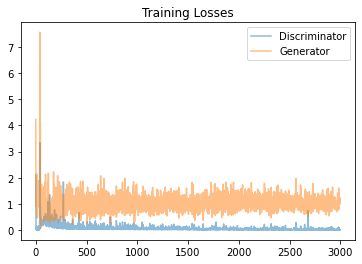

In [56]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [57]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [58]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

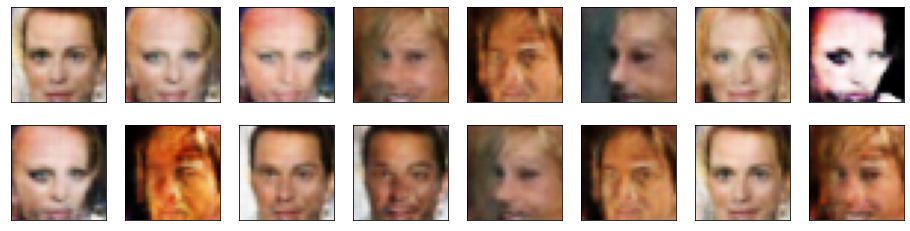

In [59]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.